In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import HistGradientBoostingRegressor

## Read data

In [2]:
df = pd.read_csv('data/medium_views_published_holidays.csv')
df = df.drop(['unique_id'], axis=1)
df.head()

,ds,y,published,is_holiday
0,2020-01-01,1131,0.0,1
1,2020-01-02,1764,0.0,0
2,2020-01-03,1699,0.0,0
3,2020-01-04,1322,0.0,0
4,2020-01-05,1491,0.0,0


### Build features

In [3]:
df['ds'] = pd.to_datetime(df['ds'])

# Extract year, month and day
df['year'] = df['ds'].dt.year
df['month'] = df['ds'].dt.month
df['day'] = df['ds'].dt.day

# Add a flag for weekend days
df['is_weekend'] = (df['ds'].dt.dayofweek >= 5).astype(int)

# Add lagged values for the past 7 days
for day in range(1, 8):
    df[f'lag_{day}'] = df['y'].shift(day)

# Assign the date to the index
df.index = df['ds']
df = df.drop(['ds'], axis=1)

df.head()

,y,published,is_holiday,year,month,day,is_weekend,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
ds,,,,,,,,,,,,,,
2020-01-01,1131,0.0,1,2020,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,1764,0.0,0,2020,1,2,0,1131.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,1699,0.0,0,2020,1,3,0,1764.0,1131.0,NaN,NaN,NaN,NaN,NaN
2020-01-04,1322,0.0,0,2020,1,4,1,1699.0,1764.0,1131.0,NaN,NaN,NaN,NaN
2020-01-05,1491,0.0,0,2020,1,5,1,1322.0,1699.0,1764.0,1131.0,NaN,NaN,NaN


## Train/test split

In [4]:
test_size = 4 * 28

X_cols = df.columns.drop(['y'])

split_date = df.index[-test_size]

X_train = df[df.index < split_date][X_cols]
y_train = df[df.index < split_date]['y']

X_test = df[df.index >= split_date][X_cols]
y_test = df[df.index >= split_date]['y']

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1269, 13) (1269,) (112, 13) (112,)


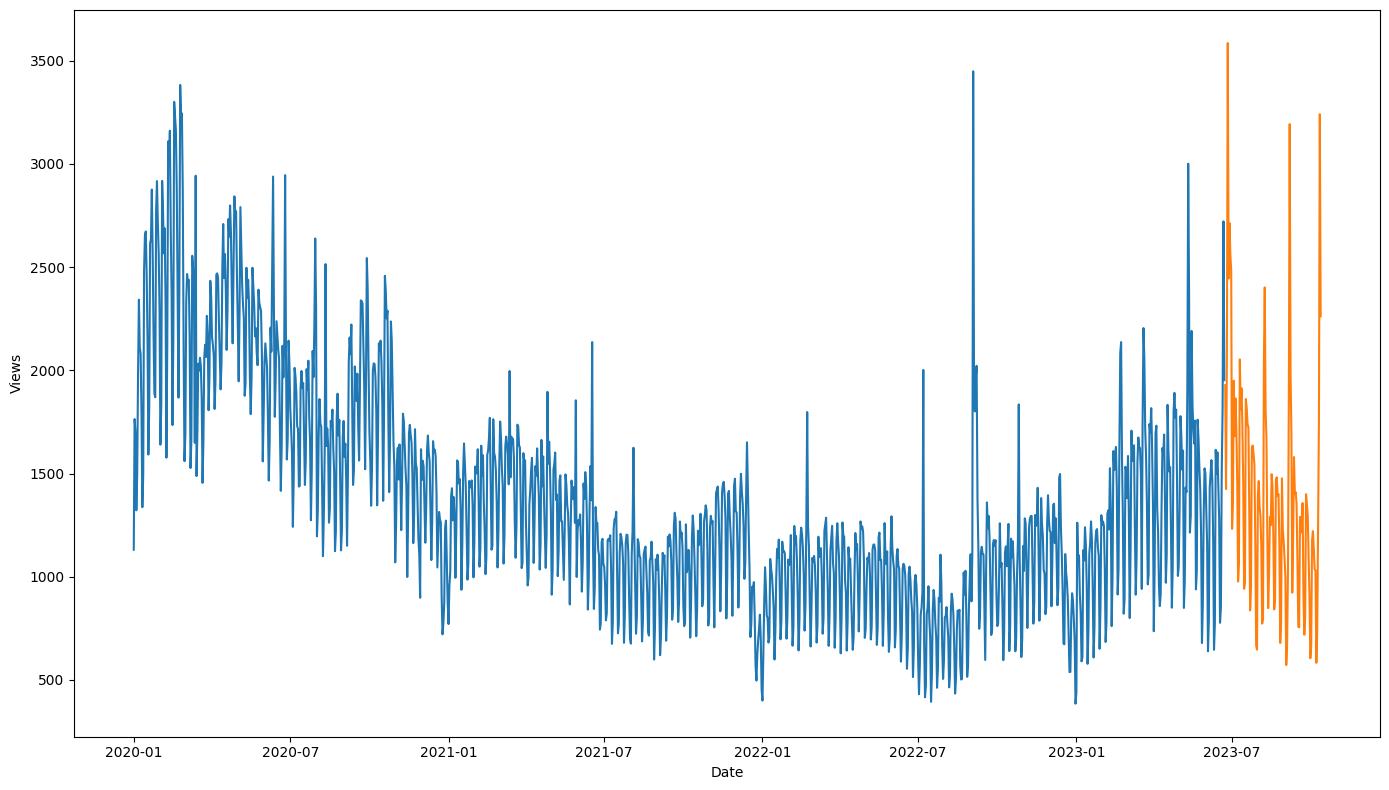

In [5]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(y_train)
ax.plot(y_test)
ax.set_xlabel('Date')
ax.set_ylabel('Views')

plt.tight_layout()

## Optimize the regressor

In [6]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

hgbr = HistGradientBoostingRegressor(random_state=42)

params = {
    "learning_rate":  ["squared_error", "absolute_error", "gamma"],
    "learning_rate": [0.1, 0.05, 0.001],
    "max_iter": [100, 150, 200],
    "min_samples_leaf": [1, 2, 3],
}

rand_search_cv = RandomizedSearchCV(
    hgbr,
    param_distributions=params,
    cv=TimeSeriesSplit(n_splits=5),
    scoring="neg_root_mean_squared_error",
    random_state=42,
    n_jobs=-1
)

rand_search_cv.fit(X_train, y_train)

model = rand_search_cv.best_estimator_

## Prediction intervals

In [7]:
from mapie.metrics import regression_coverage_score, regression_mean_width_score
from mapie.subsample import BlockBootstrap
from mapie.regression import MapieTimeSeriesRegressor

In [11]:
# For a 95% confidence interval, use alpha=0.05
alpha = 0.05
h = 1

cv_mapie_ts = BlockBootstrap(
    n_resamplings=10,
    n_blocks=9,
    overlapping=False,
    random_state=42
)

mapie_enbpi = MapieTimeSeriesRegressor(
    model,
    method='enbpi',
    cv=cv_mapie_ts,
    agg_function='mean',
    n_jobs=-1
)

In [12]:
mapie_enbpi = mapie_enbpi.fit(X_train, y_train)

y_pred, y_pred_int = mapie_enbpi.predict(
    X_test,
    alpha=alpha,
    ensemble=True,
    optimize_beta=True
)

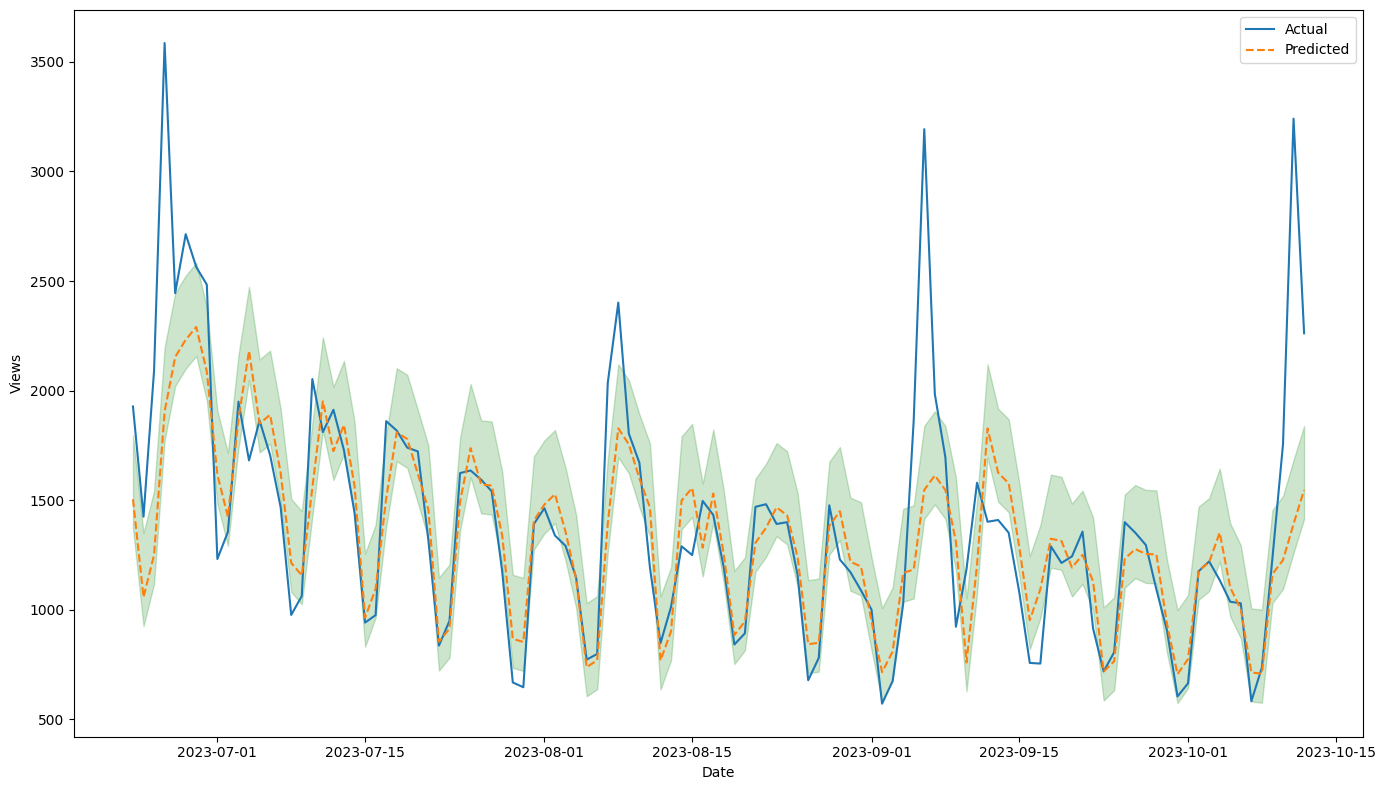

In [13]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(y_test, label='Actual')
ax.plot(y_test.index, y_pred, label='Predicted', ls='--')
ax.fill_between(
    y_test.index,
    y_pred_int[:, 0, 0],
    y_pred_int[:, 1, 0],
    color='green',
    alpha=0.2
)
ax.set_xlabel('Date')
ax.set_ylabel('Views')
ax.legend(loc='best')

plt.tight_layout()

### Prediction intervals with partial fit

In [14]:
y_pred_pfit = np.zeros(y_pred.shape)
y_pred_int_pfit = np.zeros(y_pred_int.shape)

y_pred_pfit[:h], y_pred_int_pfit[:h, :, :] = mapie_enbpi.predict(X_test.iloc[:h, :],
                                                                 alpha=alpha,
                                                                 ensemble=True,
                                                                 optimize_beta=True)

for step in range(h, len(X_test), h):
    mapie_enbpi.partial_fit(X_test.iloc[(step-h): step, :],
                             y_test.iloc[(step-h):step])
    
    y_pred_pfit[step:step + h], y_pred_int_pfit[step:step + h, :, :] = mapie_enbpi.predict(X_test.iloc[step:(step+h), :],
                                                                                           alpha=alpha,
                                                                                           ensemble=True,
                                                                                           optimize_beta=True)

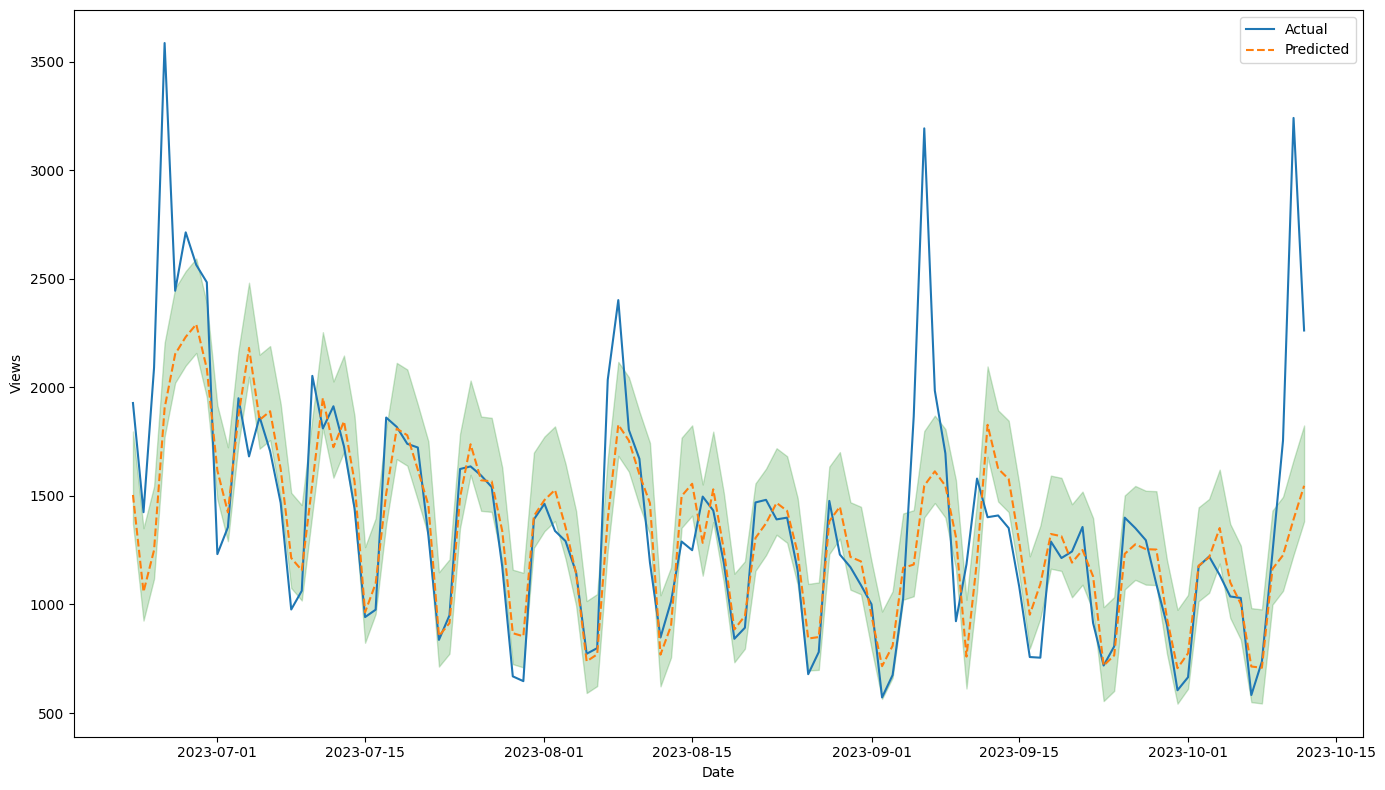

In [15]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(y_test, label='Actual')
ax.plot(y_test.index, y_pred_pfit, label='Predicted', ls='--')
ax.fill_between(
    y_test.index,
    y_pred_int_pfit[:, 0, 0],
    y_pred_int_pfit[:, 1, 0],
    color='green',
    alpha=0.2
)
ax.set_xlabel('Date')
ax.set_ylabel('Views')
ax.legend(loc='best')

plt.tight_layout()

In [16]:
coverage = regression_coverage_score(
    y_test, y_pred_int[:, 0, 0], y_pred_int[:, 1, 0]
)
width_interval = regression_mean_width_score(
    y_pred_int[:, 0, 0], y_pred_int[:, 1, 0]
)

coverage_pfit = regression_coverage_score(
    y_test, y_pred_int_pfit[:, 0, 0], y_pred_int_pfit[:, 1, 0]
)
width_interval_pfit = regression_mean_width_score(
    y_pred_int_pfit[:, 0, 0], y_pred_int_pfit[:, 1, 0]
)

print(coverage, coverage_pfit, width_interval, width_interval_pfit)

0.5803571428571429 0.6160714285714286 424.5071119838744 425.4335077233427


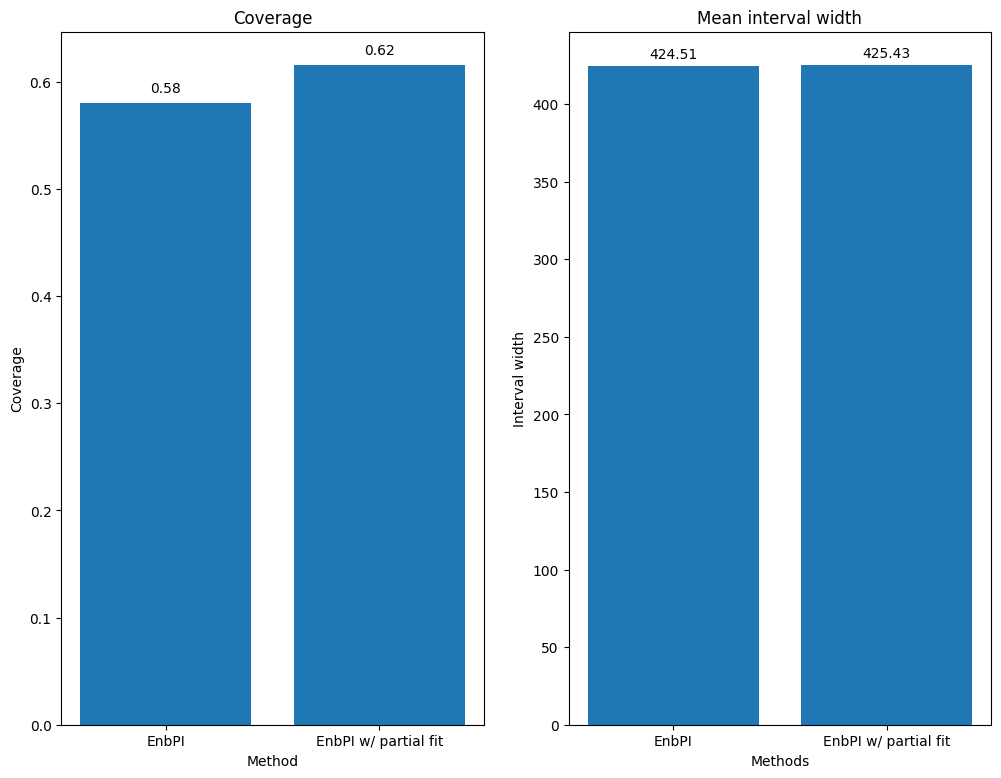

In [17]:
methods = ['EnbPI', 'EnbPI w/ partial fit']
coverages = [coverage, coverage_pfit]
widths = [width_interval, width_interval_pfit]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,9))

width = 0.25

ax1.bar(methods, coverages)
ax1.set_xlabel('Method')
ax1.set_ylabel('Coverage')
ax1.set_title('Coverage')

for i, v in enumerate(coverages):
    ax1.text(x=i, y=v+0.01, s=str(round(v,2)), ha='center')

ax2.bar(methods, widths)
ax2.set_xlabel('Methods')
ax2.set_ylabel('Interval width')
ax2.set_title('Mean interval width')

for i, v in enumerate(widths):
    ax2.text(x=i, y=v+5, s=str(round(v,2)), ha='center')